# PyVWF: Running multiple scenarios and plotting

This notebook exists for research purposes to easily run and compare all the various variations of this model:
- How spatial (no. of clusters) and temporal (from yearly to monthly) 

This code can take a long time to run as training needs to occur dependent on number of clusters.

In [1]:
import vwf.VWF_Model as model

In [4]:
cluster_list = [1,10,100,500,1000]
# cluster_list = [1,10]
# cluster_list = [1,3,5]

# time_res_list = ['yearly', 'season', 'bimonth', 'month'] 
time_res_list = ['yearly'] 

# country = "DK"
# year_test = 2020 # year you wish to receive a time series for

country = "DE"
year_test = 2019 # year you wish to receive a time series for

In [3]:
vwf_model = model.VWF(country)
vwf_model.prep()
vwf_model.train(cluster_list, time_res_list)

Total observed turbines/farms before conditions:  10931
Number of valid observed turbines/farms:  3916
yearly  on  1  clusters is trained already.
 
yearly  on  10  clusters is trained already.
 
Training for  100  clusters with time resolution:  yearly  is taking place.
Trained correction factors have been saved. Elapsed time: 111.66 seconds
 
Training for  500  clusters with time resolution:  yearly  is taking place.
Trained correction factors have been saved. Elapsed time: 206.32 seconds
 


/Users/ellyess/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD/ninja-reimplementation/vwf/bias_correction.py:22: ConvergenceWarning: Number of distinct clusters (547) found smaller than n_clusters (1000). Possibly due to duplicate points in X.
  kmeans.fit(df)


Training for  1000  clusters with time resolution:  yearly  is taking place.
Trained correction factors have been saved. Elapsed time: 198.19 seconds
 


In [5]:
vwf_model.test(year_test,cluster_list,time_res_list)

Total observed turbines/farms before conditions:  10931
Number of valid observed turbines/farms:  4778
Test for  1  clusters with time resolution:  yearly  is taking place.
Results completed and saved. Elapsed time: 7.66 seconds
 
Test for  10  clusters with time resolution:  yearly  is taking place.
Results completed and saved. Elapsed time: 7.36 seconds
 
Test for  100  clusters with time resolution:  yearly  is taking place.
Results completed and saved. Elapsed time: 7.45 seconds
 
Test for  500  clusters with time resolution:  yearly  is taking place.
Results completed and saved. Elapsed time: 7.41 seconds
 
Test for  1000  clusters with time resolution:  yearly  is taking place.
Results completed and saved. Elapsed time: 7.52 seconds
 


In [5]:
# # running for merra

# vwf_model = model.VWF(country, year_star, year_end, year_test)
# vwf_model.test_merra(time_res)

In [6]:
# import time
# import xarray as xr
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from vwf.extras import calc_metrics_era5
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib

bg_colour = '#f0f0f0'
custom_params = {'xtick.bottom': True, 'axes.edgecolor': 'black', 'axes.spines.right': False, 'axes.spines.top': False, 'axes.facecolor': bg_colour}
sns.set_theme(style='darkgrid', rc=custom_params)

In [ ]:
def calc_metrics_era5(year_test, country, cluster_list, time_res_list=['yearly', 'season', 'bimonth', 'month']):
    turb_info = pd.read_csv('data/training/simulated-turbines/'+country+"_"+str(year_test)+'_turb_info.csv')
    cf_obs = pd.read_csv('data/results/capacity-factor/'+country+"_"+str(year_test)+'_obs_cf.csv', parse_dates=['time'])
    cf_unc = pd.read_csv('data/results/capacity-factor/'+country+"_"+str(year_test)+'_unc_cf.csv', parse_dates=['time'])

    cf_obs_month = weighted_monthly_cf(cf_obs, turb_info)
    cf_unc_month = weighted_monthly_cf(cf_unc, turb_info)

    months = np.array(range(1,13))
    diff = cf_unc_month - cf_obs_month
    abs_err = abs(diff)
    
    df_unc = pd.DataFrame({'month':months, 'abs_err':abs_err, 'diff': diff})
    df_unc['num_clu'] = 1
    df_unc['time_res'] = 'uncorrected'

    # loading and calculating every scenario we simulated for comparison
    abs_diff_calc = []
    cluster_all = []
    time_all = []
    month_all = []
    diff_calc = []
    for num_clu in cluster_list:
        for time_res in time_res_list:
            cf_cor = pd.read_csv('data/results/capacity-factor/'+country+"_"+str(year_test)+'_'+time_res+'_'+str(num_clu)+'_cor_cf.csv', parse_dates=['time'])
            cf_cor_month = weighted_monthly_cf(cf_cor, turb_info)
            
            diff = cf_cor_month - cf_obs_month 
            abs_diff = abs(diff)
            
            abs_diff_calc.append(abs_diff)
            diff_calc.append(diff)
            cluster_all.append([num_clu]*12)
            time_all.append([time_res]*12)
            month_all.append(months)
                

    df_cor = pd.DataFrame(list(zip(np.ravel(cluster_all), np.ravel(time_all), np.ravel(month_all), np.ravel(abs_diff_calc), np.ravel(diff_calc))), 
                 columns =['num_clu', 'time_res', 'month', 'abs_err', 'diff'])
    
    df_metrics = pd.concat([df_cor,df_unc]).reset_index(drop=True)
    
    # converting it to rmse and mae
    df_metrics['se'] = df_metrics['abs_err']**2
    rmse = np.sqrt(df_metrics.groupby(['num_clu', 'time_res'])['se'].mean()).reset_index()
    clus_metrics = df_metrics.groupby(['num_clu', 'time_res'])['abs_err'].mean().reset_index()
    clus_metrics['RMSE'] = rmse['se']
    clus_metrics.columns = ['num_clu', 'time_res', 'MAE', 'RMSE']

    df_metrics['se'] = np.sqrt(df_metrics['se'])
    df_metrics.columns = ['num_clu','time_res','month', 'AE', 'diff', 'RMSE']
    
    return clus_metrics, df_metrics

In [8]:
clus_metrics, month_metrics  = calc_metrics_era5(year_test, country, cluster_list, time_res_list) 

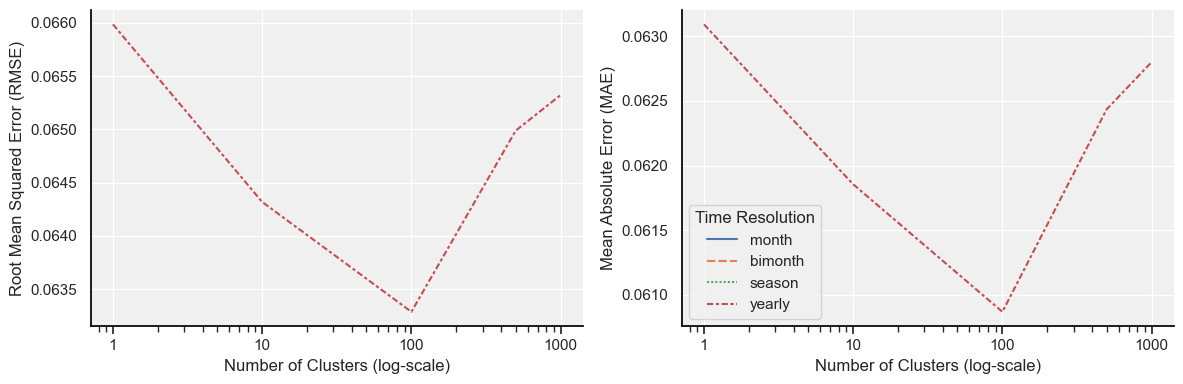

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    x='num_clu',
    y='RMSE',
    hue ="time_res",
    style="time_res",
    hue_order = ['month', 'bimonth', 'season', 'yearly'],
    style_order= ['month', 'bimonth', 'season', 'yearly'],
    data = clus_metrics[(clus_metrics['time_res'] != 'uncorrected')],
    ax = axes[0],
    legend = False
)
axes[0].set_xscale('log')
axes[0].set_ylabel('Root Mean Squared Error (RMSE)')
axes[0].set_xlabel('Number of Clusters (log-scale)')
axes[0].set_xticks([1, 10, 100,1000])
axes[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

sns.lineplot(
    x='num_clu',
    y='MAE',
    hue ="time_res",
    style= "time_res",
    hue_order = ['month', 'bimonth', 'season', 'yearly'],
    style_order= ['month', 'bimonth', 'season', 'yearly'],
    data = clus_metrics[(clus_metrics['time_res'] != 'uncorrected')],
    ax = axes[1],
    legend = True
)

axes[1].set_xscale('log')
axes[1].set_ylabel('Mean Absolute Error (MAE)')
axes[1].set_xlabel('Number of Clusters (log-scale)')
axes[1].set_xticks([1, 10, 100,1000])
axes[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# fixing the legend labels and sharing it over whole plot.
axes[1].get_legend().remove()
handles, labels = plt.gca().get_legend_handles_labels()
# labels = ['Monthly', 'Bimonthly',  'Seasonal', 'Yearly'] # renaming labels
plt.legend(handles, labels, ncol=1, loc='lower left', title='Time Resolution')
plt.savefig("data/plots/"+country+"_full_error.png", bbox_inches='tight')
plt.tight_layout()